# PSL-2 Assignment 5

## Student Details

Rajas Mehendale

18CHE160

T.Y.B. Chem.Engg

ICT, Mumbai

## Unsteady State Countercurrent Heat Exchanger 

UPWIND DIFFERENCING

(Forward Difference in the direction of flow)


Hot Side


$$
        \frac{dH_H^{(j)}}{dt} = \frac{m_H}{A_c \rho_H \Delta z} H_H^{(j-1)} - \frac{m_H}{A_c \rho_H \Delta z} H_H^{(j)}  - \frac{UP}{A_c \rho_H} \left( T_H^{(j)} - T_C^{(j)} \right)    
$$




Cold Side


$$
        \frac{dH_C^{(j)}}{dt} = \frac{m_C}{A_c \rho_C \Delta z} H_C^{(j+1)} - \frac{m_C}{A_c \rho_C \Delta z} H_C^{(j)}  + \frac{UP}{A_c \rho_C} \left( T_H^{(j)} - T_C^{(j)} \right)      
$$



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.integrate
import scipy.interpolate
import scipy.optimize
from matplotlib import style
from matplotlib.animation import FuncAnimation

from IPython.display import display, Math, Image
%config InlineBackend.figure_format = 'svg'

style.use('seaborn-bright')

## Defining Enthalpy - Temperature Relationship



${T}_{reference} =$ 273.16K = 25.0 ${}^{o}$Celsius



In [2]:
def integrand(T,cp):
    I = (cp[0])+(cp[1]*T)+(cp[2]*(T**2))+(cp[3]*(T**3))+(cp[4]*(T**4))
    return I
def H_H(T): #T in K
    cp = [10483000, -115220, 476.87, -0.85381, 0.00056246]
    # 1-Nonanol
    I1 = (cp[0]/1)* (np.power(T,1)-np.power(273.16,1))
    I2 = (cp[1]/2)* (np.power(T,2)-np.power(273.16,2))
    I3 = (cp[2]/3)* (np.power(T,3)-np.power(273.16,3))
    I4 = (cp[3]/4)* (np.power(T,4)-np.power(273.16,4))
    I5 = (cp[4]/5)* (np.power(T,5)-np.power(273.16,5))
    H   = (I1+I2+I3+I4+I5)/(144.225) #J/(kg-K)
    return H
    
def H_C(T): # T in K
    # Water
    cp =  [276370, -2090.1, 8.125, -0.014116, 9.3701E-06]
    I1 = (cp[0]/1)* (np.power(T,1)-np.power(273.16,1))
    I2 = (cp[1]/2)* (np.power(T,2)-np.power(273.16,2))
    I3 = (cp[2]/3)* (np.power(T,3)-np.power(273.16,3))
    I4 = (cp[3]/4)* (np.power(T,4)-np.power(273.16,4))
    I5 = (cp[4]/5)* (np.power(T,5)-np.power(273.16,5))
    H   = (I1+I2+I3+I4+I5)/(18.015) #J/(kg-K)
    return H
tmin = 280; tmax=380; 
T = np.linspace(tmin, tmax, 2000);
T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0);
T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0);

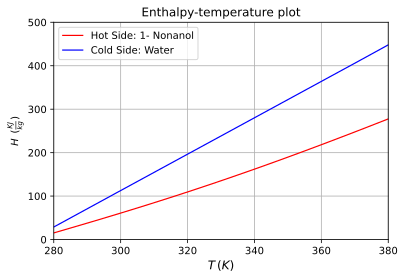

In [3]:
plt.figure(facecolor='white')
plt.grid()

plt.title("Enthalpy-temperature plot")
plt.plot(T, H_H(T)/1000, color='red', linewidth=1.2, label='Hot Side: 1- Nonanol')
plt.plot(T, H_C(T)/1000, color='blue', linewidth=1.2, label='Cold Side: Water')
plt.xlabel(r'$T\, (K)$',fontsize=12)
plt.ylabel(r'$H\ \, (\frac{KJ}{kg})$',fontsize=10)
plt.xlim([tmin,tmax]); plt.ylim([0,500])
plt.legend(loc='best',fontsize=10);

In [4]:
class CounterCurrentHX:
    def __init__(self, n):
        #n = no of line points
        self.U = 400.0  # W/m2-K
        self.P = np.pi * 0.1  # m2/m
        self.AcH = np.pi * 0.25 * 0.1 ** 2  # m2
        self.AcC = np.pi * 0.25 * 0.1 ** 2  # m2
        self.L = 2.0  # m
        
        self.rhoH = 830.0 # kg/m3
        self.rhoC = 1000.0 # kg/m3
        
        self.mH = 0.1  # kg/s
        self.mC = 0.09  # kg/s
        
        self.T_Hin = 50 + 273.16  # K
        self.T_Cin = 10  + 273.16  # K
        
        
        self.cv_timescale = self.L/(((self.mH/self.rhoH)/(self.AcH)))
        heatrate = (self.U*self.AcH*(20))     
        self.ht_timescale = ((20)*3300*(self.mH)*(1+1.1*self.mH/self.mC))/heatrate
        print("Timescales:\nConvection   = %.0f seconds\n" %(self.cv_timescale))
        print(             "Heat Transfer= %.0f seconds\n" %(self.ht_timescale))
        self.n = n # Number of grid points

    def model(self, H, t): 
        H_hot = H[:self.n]
        H_cold = H[self.n:]

        T_hot = T_H(H_hot)
        T_cold = T_C(H_cold)
        
        H_Hin = H_H(self.T_Hin)
        H_Cin = H_C(self.T_Cin)
        
        dz = self.L / self.n
        
        dH_hotdt = np.zeros(self.n)
        dH_colddt = np.zeros(self.n)
        
        dH_hotdt[1:] = self.mH / (self.AcH * self.rhoH * dz) * H_hot[0:-1] - self.mH / (self.AcH * self.rhoH * dz) * H_hot[1:] - self.U * self.P / (self.AcH * self.rhoH) * (T_hot[1:] - T_cold[1:]) 
        dH_colddt[:-1] = self.mC / (self.AcC * self.rhoC * dz) * H_cold[1:] - self.mC / (self.AcC * self.rhoC * dz) * H_cold[:-1] + self.U * self.P / (self.AcC * self.rhoC) * (T_hot[:-1] - T_cold[:-1]) 
        
        dH_hotdt[0] = self.mH / (self.AcH * self.rhoH * dz) * H_Hin - self.mH / (self.AcH * self.rhoH * dz) * H_hot[0] - self.U * self.P / (self.AcH * self.rhoH) * (T_hot[0] - T_cold[0]) 
        dH_colddt[-1] = self.mC / (self.AcC * self.rhoC * dz) * H_Cin - self.mC / (self.AcC * self.rhoC * dz) * H_cold[-1] + self.U * self.P / (self.AcC * self.rhoC) * (T_hot[-1] - T_cold[-1]) 

        return list(dH_hotdt) + list(dH_colddt)

    def solve(self, t):
        Tini = np.ones(self.n * 2) * self.T_Cin
#         Tini[:self.n] = Tini[:self.n] * self.T_Hin
#         Tini[self.n:] = Tini[self.n:] * self.T_Cin
        H0 = np.zeros(self.n * 2)
        H0[:self.n] = H_H(Tini[:self.n])
        H0[self.n:] = H_C(Tini[self.n:])
        
        sol = scipy.integrate.odeint(self.model, H0, t)
        
        dz = self.L / self.n
        pos = [(i + 0.5) * dz for i in range(self.n)] 

        self.t = t
        self.pos = pos
        self.sol = sol

In [5]:
def solve_plot_gif(n, time_period,interval,mH,mC):
    t = np.linspace(0, time_period, n)
    hx = CounterCurrentHX(n)
    hx.mH = mH  # kg/s
    hx.mC = mC  # kg/s
    hx.solve(t)
    
    
    fig = plt.figure(facecolor='white', figsize=(5, 5))
    plt.suptitle("Temperature vs Length of Heat Exchanger (n = %d)" % n)
    plt.grid()
    plt.xlabel('Length (z)'); plt.ylabel('Temperature (K)');
    plt.xlim(0, hx.L)
    plt.ylim(0.97 * hx.T_Cin, 1.02 * hx.T_Hin)
    plt.annotate(r'$T_H^{in}$', xy=(0, hx.T_Hin), fontsize = 10)
    plt.annotate(r'$T_C^{in}$', xy=(hx.L, hx.T_Cin), fontsize = 10)
    
    line1 = plt.plot([], 'r', label='Hot side')[0]
    line2 = plt.plot([], 'b', label='Cold side')[0]
    plt.legend(loc='best', fontsize=9)
    textstr =("Timescale (seconds)\n"+ 
                 "Convection = %.0f\n" %(hx.cv_timescale)+ 
                 "Heat Transfer = %.0f\n" %(hx.ht_timescale))
    props = dict(boxstyle='round', facecolor='gold', alpha=0.5)
    fig.text(0.95, 0.5, textstr, fontsize=10,
    verticalalignment='top', bbox=props);
    def animated_plot(i):  
        i = int(i)
        plt.title(r"$t = %d$" % hx.t[i])
        line1.set_data((hx.pos, T_H(hx.sol[i][:hx.n]))) 
        line2.set_data((hx.pos, T_C(hx.sol[i][hx.n:]))) 
        return line1, line2
     
    animation = FuncAnimation(fig, animated_plot, frames=n, interval=interval);
    animation.save('cchx_pde_n_%d_t_%d.gif' % (n, time_period), writer='pillow', fps=30)
    return Image(url='cchx_pde_n_%d_t_%d.gif' % (n, time_period))

Timescales:
Convection   = 130 seconds

Heat Transfer= 233 seconds



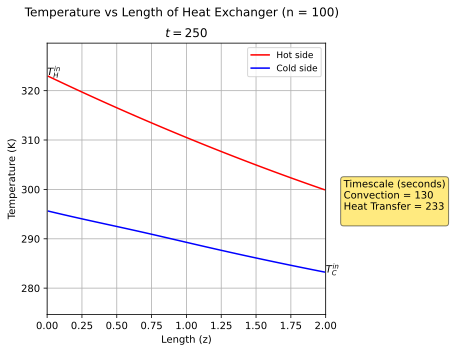

In [6]:
time_period = 250
n=100
interval  = 175
mH = 0.1  # kg/s
mC = 0.09  # kg/s
solve_plot_gif(n, time_period,interval,mH,mC)

Timescales:
Convection   = 130 seconds

Heat Transfer= 233 seconds



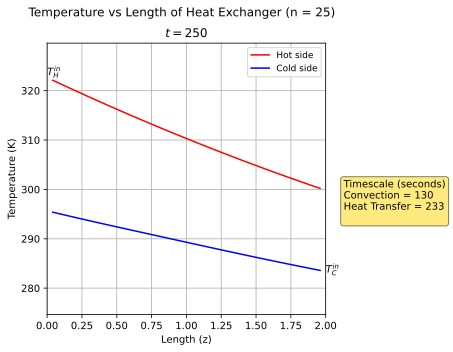

In [7]:
time_period = 250
n=25
interval  = 1000
mH = 0.1  # kg/s
mC = 0.09  # kg/s
solve_plot_gif(n, time_period,interval,mH,mC)

Timescales:
Convection   = 130 seconds

Heat Transfer= 233 seconds



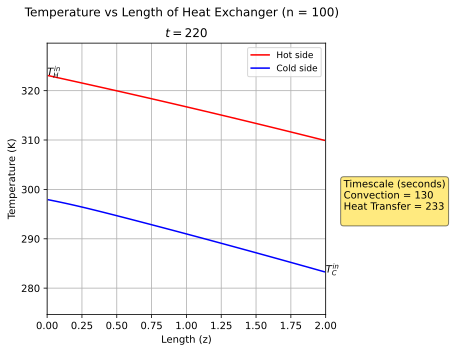

In [8]:
time_period = 220
n=100
interval  = 200
mH = 0.2  # kg/s
mC = 0.1  # kg/s
solve_plot_gif(n, time_period,interval,mH,mC)

Timescales:
Convection   = 130 seconds

Heat Transfer= 233 seconds



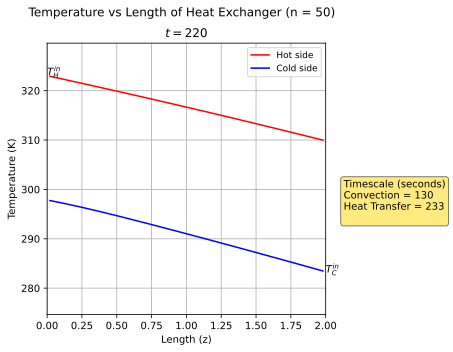

In [9]:
time_period = 220
n=50
interval  = 1000
mH = 0.2  # kg/s
mC = 0.1  # kg/s
solve_plot_gif(n, time_period,interval,mH,mC)

Timescales:
Convection   = 130 seconds

Heat Transfer= 233 seconds



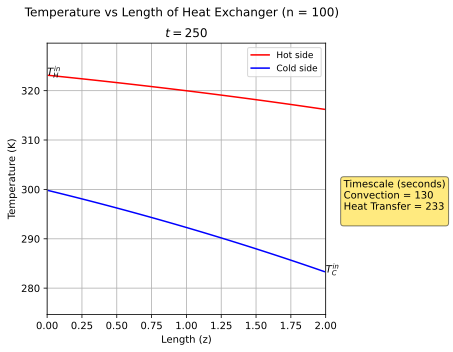

In [10]:
time_period = 250
n=100
interval  = 500
mH = 0.4  # kg/s
mC = 0.1  # kg/s
solve_plot_gif(n, time_period,interval,mH,mC)

Timescales:
Convection   = 130 seconds

Heat Transfer= 233 seconds



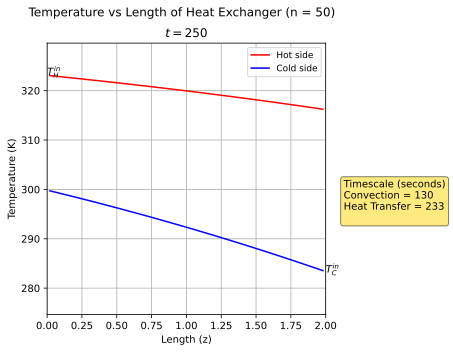

In [11]:
time_period = 250
n=50
interval  = 1000
mH = 0.4  # kg/s
mC = 0.1  # kg/s
solve_plot_gif(n, time_period,interval,mH,mC)